# Exploratory Data Analysis (EDA)

Nesse jupyter notebook se encontram os passos da análise exploratória dos dados, assim como conclusões intermediárias que foram encontradas.

## Importando os arquivos e analisando os dados

In [1]:
!pip install seaborn

In [2]:
!pip install -U scikit-learn

In [3]:
!pip install xgboost

In [4]:
import pandas as pd

In [5]:
catalog.list()

['training_dataset', 'test_dataset', 'parameters']

In [6]:
df = catalog.load('training_dataset')

[02/17/23 17:13:20] INFO     Loading data from 'training_dataset' (CSVDataSet)...               data_catalog.py:343

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Tambem foi disponibilizado um dicionário:
    
Variável|Definição|Key
--------|----------|---
survival|Indica se o passageiro sobreviveu|0 = Não, 1 = Sim
pclass|Classe do passageiro|1 = Primeira, 2 = Segunda, 3 = Terceira
sex|Genero|
Age|Idade em anos|
sibsp|número de parentes/cônjuges a bordo do Titanic|
parch|numero de pais/filhos a bordo do Titanic|
ticket|Número do ticket|
fare|Valor pago pelo passageiro|
cabin|Número da cabine|
embarked|Porto de embarque|C = Cherbourg, Q = Queenstown, S = Southampton  

Após a aplicação dos métodos `info()` e `head()`, foram feitas algumas conclusões:

1 - As variáveis `Age`, `Cabin` e `Embarked` possuem informações nulas. Essa colunas deverão ser analizadas mais profundamente para entender o motivo.

2 - A variável `PassengerId` contém informações únicas para todas as linhas e não será útil em análises, por isso ela será removida do DataFrame. A *feature* `Ticket` também parece conter informações únicas e será analisada mais a fundo.

3 - As colunas `SibSp` e `Parch` contém informações sobre a quantidade de familiares. Análises posteriores serão efetuadas para a possibilidade de união das duas colunas.

4 - A variável `Name` possui, além do nome, informações a respeito de títulos de cada passageiro. Ela pode ser analisada mais a fundo.

5 - Há variáveis numéricas discretas e variáveis categóricas. As variáveis categóricas deverão ser tratadas durante a etapa de *feature engeneering*.

## Entendendo as colunas

### `PassengerId`, `Ticket` e `Cabin`

Primeiro vamos remover a coluna `PassengerId`, que não será aproveitada:

In [9]:
df = df.drop(columns = 'PassengerId')

Podemos também analisar a coluna `Ticket`:

In [10]:
df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

A coluna apresenta passageiros com o mesmo cartão, mas apresenta 681 valores únicos. Por isso ela também será removida

In [11]:
df = df.drop(columns = 'Ticket')

Outra coluna que pode ser analisada para remoção é a coluna `Cabin`. Ela contém valores nulos.

In [12]:
df['Cabin'].isnull().value_counts()

True     687
False    204
Name: Cabin, dtype: int64

Por apresentar um grande número de valores nulos, essa coluna será removida.

In [13]:
df = df.drop(columns = 'Cabin')

In [14]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### Colunas `Age` e `Embarked`

Primeiramente vamos olhar para a coluna `Embarked`, que sinaliza o porto de embarque de cada passageiro.

In [15]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Na análise com o método `info()`, foram descobertos valores nulos. Vamos pegar apenas esses registros e verificar:

In [16]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


Podemos verificar como é a distribuição de sobreviventes entre portos, para saber se há a necessidade de manter essa coluna.

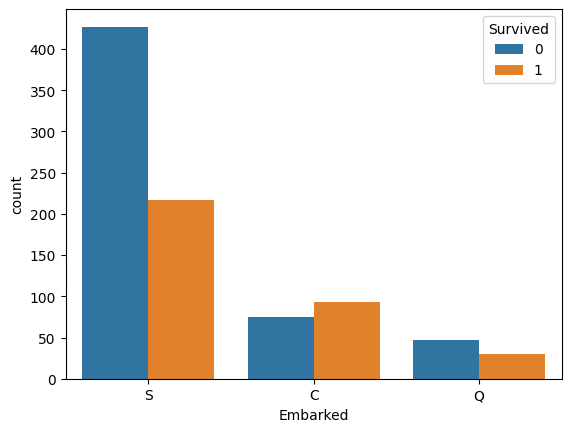

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Embarked', hue = 'Survived')

Como a coluna apresenta uma distribuição diferente para cada porto, é interessante manter essa coluna para análises futuras. Já a coluna `Age` precisa ser analisada também

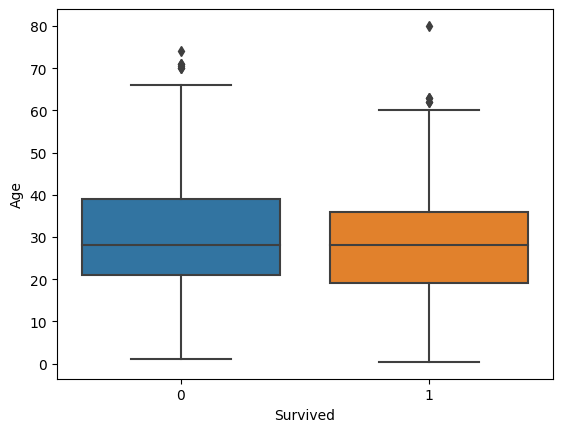

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.boxplot(data = df, y = 'Age', x = 'Survived')

Analisando o gráfico se percebe uma pequena diferença entre as distribuições das idades de quem sobreviveu ou não. Essa diferença, no entanto, não parece ser acentuada. Os valores faltantes na coluna serão substituídos pela média de idade do grupo que a pessoa pertence: se sobreviveu ou não.

In [19]:
## botando a média de idade

sobreviveram = df.query('Survived == 1')
nao_sobreviveram = df.query('Survived == 0')

In [20]:
media_sobreviveram = sobreviveram['Age'].mean()
sobreviveram['Age'].fillna(value = media_sobreviveram, inplace = True)
sobreviveram

[02/17/23 17:13:37] WARNING  C:\Users\vinic\AppData\Local\Temp\ipykernel_16604\3010192157.py:2:     warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               sobreviveram['Age'].fillna(value = media_sobreviveram, inplace =                    
                             True)                                                                                 
                                                                                                                   

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C
...,...,...,...,...,...,...,...,...,...
875,1,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,7.2250,C
879,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,83.1583,C
880,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,26.0000,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,30.0000,S


In [21]:
media_nao_sobreviveram = nao_sobreviveram['Age'].mean()
nao_sobreviveram['Age'].fillna(value = media_nao_sobreviveram, inplace = True)
nao_sobreviveram

[02/17/23 17:13:38] WARNING  C:\Users\vinic\AppData\Local\Temp\ipykernel_16604\2827402909.py:2:     warnings.py:109
                             SettingWithCopyWarning:                                                               
                             A value is trying to be set on a copy of a slice from a DataFrame                     
                                                                                                                   
                             See the caveats in the documentation:                                                 
                             https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#                
                             returning-a-view-versus-a-copy                                                        
                               nao_sobreviveram['Age'].fillna(value = media_nao_sobreviveram,                      
                             inplace = True)                                                                       
                                                                                                                   

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,7.2500,S
4,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,8.0500,S
5,0,3,"Moran, Mr. James",male,30.626179,0,0,8.4583,Q
6,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,51.8625,S
7,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,21.0750,S
...,...,...,...,...,...,...,...,...,...
884,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,7.0500,S
885,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,29.1250,Q
886,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.626179,1,2,23.4500,S


In [22]:
# Após a aplicação da média, é necessário concatenar novamente os dataframes

df = pd.concat([sobreviveram, nao_sobreviveram],ignore_index=True)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,71.2833,C
1,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,7.9250,S
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,53.1000,S
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,11.1333,S
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,30.0708,C
...,...,...,...,...,...,...,...,...,...
886,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,7.0500,S
887,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.000000,0,5,29.1250,Q
888,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,13.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,30.626179,1,2,23.4500,S


### Colunas `SibSp` e `Parch`

Essa duas colunas possuem informações sobre parentes de cada passageiro. Por isso, essas colunas serão resumidas em uma coluna que informa o total de familiares de cada passageiro.

In [23]:
df['FamilyMembers'] = df['SibSp'] + df['Parch']
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilyMembers
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1
1,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,11.1333,S,2
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,30.0708,C,1


Após isso, podemos excluir as duas colunas de análises futuras.

In [24]:
df = df.drop(columns = ['SibSp', 'Parch'])

In [25]:
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilyMembers
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1
1,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,11.1333,S,2
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,30.0708,C,1


### Variáveis `Sex` e `Pclass`

Para essa variável, será necessário aplicar técnicas de encoding para tratar as informações. Podemos verificar como é a diferença de sobrevivencia entre os gêneros

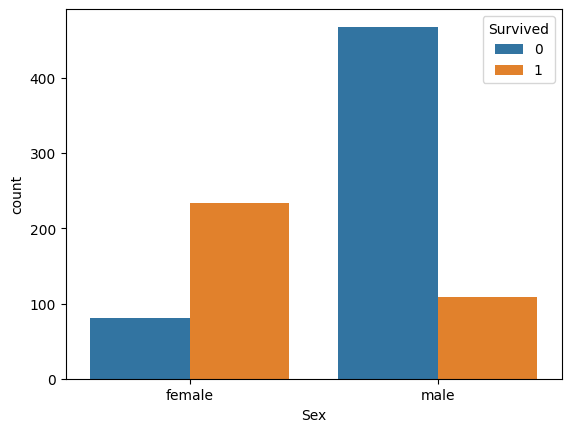

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Sex', hue = 'Survived')

É possível perceber que mais mulheres sobreviveram que os homens. Isso pode ter diversos motivos.

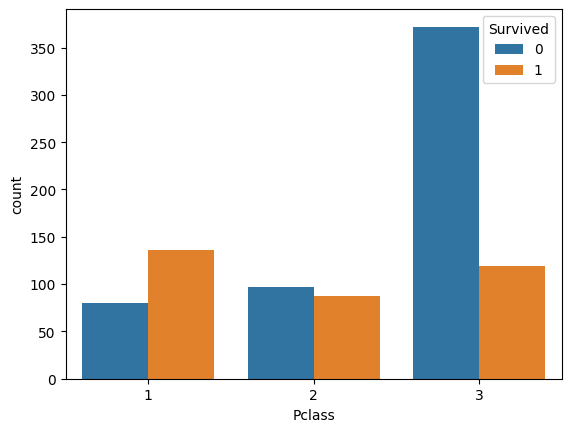

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Pclass', hue = 'Survived')

Essa é outra variável categórica que apresenta um comportamento interessante para a variável target.

### Coluna `Name`

A coluna Name possui informações únicas, porém é possível gerar novas features ao se analisar os títulos de cada passageiro. 

In [28]:
df['Name']

0      Cumings, Mrs. John Bradley (Florence Briggs Th...
1                                 Heikkinen, Miss. Laina
2           Futrelle, Mrs. Jacques Heath (Lily May Peel)
3      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
4                    Nasser, Mrs. Nicholas (Adele Achem)
                             ...                        
886                               Sutehall, Mr. Henry Jr
887                 Rice, Mrs. William (Margaret Norton)
888                                Montvila, Rev. Juozas
889             Johnston, Miss. Catherine Helen "Carrie"
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [29]:
## Pega apenas o título de cada nome
titulo_com_nome = df['Name'].str.split(pat = ', ').str[1]
titulo_sem_nome = titulo_com_nome.str.split().str[0]
df['Title'] = titulo_sem_nome
df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilyMembers,Title
0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,C,1,Mrs.
1,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,S,0,Miss.
2,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,S,1,Mrs.
3,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,11.1333,S,2,Mrs.
4,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,30.0708,C,1,Mrs.


Com a coluna sendo criada, pode-se comparar também a taxa de mortalidade entre os diferentes títulos

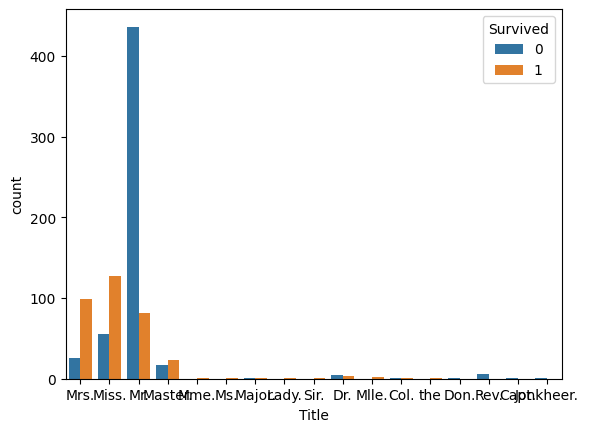

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.countplot(data = df, x = 'Title', hue = 'Survived')

In [31]:
df['Title'].unique()

array(['Mrs.', 'Miss.', 'Mr.', 'Master.', 'Mme.', 'Ms.', 'Major.',
       'Lady.', 'Sir.', 'Dr.', 'Mlle.', 'Col.', 'the', 'Don.', 'Rev.',
       'Capt.', 'Jonkheer.'], dtype=object)

As tentativas feitas não obtiveram sucesso. Apesar da possibilidade de agrupar, alguns títulos aparecem muito pouco. Além disso, os títulos também possuem ligação com o sexo do passageiro, o que poderia gerar comportamento indesejado do sistema. Por conta disso, essa coluna será removida das análises futuras.

In [32]:
colunas = ['Title', 'Name']

df = df.drop(columns = colunas)

In [33]:
df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilyMembers
0,1,1,female,38.0,71.2833,C,1
1,1,3,female,26.0,7.9250,S,0
2,1,1,female,35.0,53.1000,S,1
3,1,3,female,27.0,11.1333,S,2
4,1,2,female,14.0,30.0708,C,1


Com essa EDA, o número de variáveis caiu de 9 para 6. Isso é ruim por conta disso e bom por conta daquilo.

In [34]:
df.to_csv('data/02_intermediate/after_eda.csv')

## Feature Engineering

Na parte de feature engineering, devemos criar dummies para as colunas categóricas textuais. Para esse projeto, as variáveis numéricas não serão tratadas.

In [35]:
categoricas = ['Sex','Embarked']

df_encoded = pd.get_dummies(data = df, columns = categoricas)
df_encoded

,Survived,Pclass,Age,Fare,FamilyMembers,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,1,38.000000,71.2833,1,1,0,1,0,0
1,1,3,26.000000,7.9250,0,1,0,0,0,1
2,1,1,35.000000,53.1000,1,1,0,0,0,1
3,1,3,27.000000,11.1333,2,1,0,0,0,1
4,1,2,14.000000,30.0708,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0,3,25.000000,7.0500,0,0,1,0,0,1
887,0,3,39.000000,29.1250,5,1,0,0,1,0
888,0,2,27.000000,13.0000,0,0,1,0,0,1
889,0,3,30.626179,23.4500,3,1,0,0,0,1


In [36]:
df_encoded

,Survived,Pclass,Age,Fare,FamilyMembers,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,1,38.000000,71.2833,1,1,0,1,0,0
1,1,3,26.000000,7.9250,0,1,0,0,0,1
2,1,1,35.000000,53.1000,1,1,0,0,0,1
3,1,3,27.000000,11.1333,2,1,0,0,0,1
4,1,2,14.000000,30.0708,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
886,0,3,25.000000,7.0500,0,0,1,0,0,1
887,0,3,39.000000,29.1250,5,1,0,0,1,0
888,0,2,27.000000,13.0000,0,0,1,0,0,1
889,0,3,30.626179,23.4500,3,1,0,0,0,1


Com as colunas encodadas, é possível iniciar os testes com modelos de machine learning

In [37]:
df_encoded.to_csv('data/02_intermediate/df_encoded.csv')

## Machine learning

Como a base de dados já trouxe datasets distintos para treino e teste, não será necessário dividir os dados já tratados. É necessário, no entanto, separar a variável target.

In [39]:
from sklearn.model_selection import train_test_split

SEED = 42

X = df_encoded.drop(columns = 'Survived')
y = df_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify = y)

In [40]:
def executa_modelo(modelo):

    modelo.fit(X_train,y_train)
    y_pred = modelo.predict(X_test)

    return y_pred

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier


SEED = 42

dummy = DummyClassifier(random_state = SEED)
lr = LogisticRegression(max_iter = 1000, random_state = SEED)
rf = RandomForestClassifier(random_state = SEED)
xgboost = XGBClassifier()

modelos = [dummy, lr, rf, xgboost]
resultados = {}


for modelo in modelos:
    y_pred = executa_modelo(modelo)
    resultados[modelo] = y_pred

resultados

{
    DummyClassifier(random_state=42): array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64),
    LogisticRegression(max_iter=1000, random_state=42): array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1], dtype=int64),
    RandomForestClassifier(random_state=42): array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1], dtype=int64),
    XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...): array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       

In [1]:
from sklearn import metrics

def valida_modelo(modelo, y_test, y_pred):
    acuracia = metrics.accuracy_score(y_test, y_pred).round(4)
    precisao = metrics.precision_score(y_test, y_pred,zero_division=0).round(4)
    recall = metrics.recall_score(y_test, y_pred,zero_division=0).round(4)
    f1 = metrics.f1_score(y_test, y_pred,zero_division=0).round(4)

    metricas = [acuracia, precisao, recall, f1]

    return metricas

In [2]:
index = ['Acurácia', 'Precisão', 'Recall', 'F1']
df_metricas = pd.DataFrame(index = index)

for modelo, resultado in resultados.items():
    df_metricas[modelo] = valida_modelo(modelo, y_test, resultado)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ C:\Users\vinic\AppData\Local\Temp\ipykernel_16144\2003369590.py:2 in <cell line: 2>              │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ 'C:\\Users\\vinic\\AppData\\Local\\Temp\\ipykernel_16144\\2003369590.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'pd' is not defined

In [51]:
df_metricas

<repr-error 'tuple index out of range'>

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ c:\users\vinic\desktop\lighthouse\desafio final                                                  │
│ ds\desafio-lh-ds\venv\lib\site-packages\IPython\core\formatters.py:224 in catch_format_error     │
│                                                                                                  │
│    221 def catch_format_error(method, self, *args, **kwargs):                                    │
│    222 │   """show traceback on failed format call"""                                            │
│    223 │   try:                                                                                  │
│ ❱  224 │   │   r = method(self, *args, **kwargs)                                                 │
│    225 │   except NotImplementedError:                                                           │
│    226 │   │   # don't warn on NotImplementedErrors                                              │
│    227 │   │   return self._check_return(None, args[0])                                          │
│                                                                                                  │
│ c:\users\vinic\desktop\lighthouse\desafio final                                                  │
│ ds\desafio-lh-ds\venv\lib\site-packages\IPython\core\formatters.py:345 in __call__               │
│                                                                                                  │
│    342 │   │   │   # Finally look for special method names                                       │
│    343 │   │   │   method = get_real_method(obj, self.print_method)                              │
│    344 │   │   │   if method is not None:                                                        │
│ ❱  345 │   │   │   │   return method()                                                           │
│    346 │   │   │   return None                                                                   │
│    347 │   │   else:                                                                             │
│    348 │   │   │   return None                                                                   │
│                                                                                                  │
│ c:\users\vinic\desktop\lighthouse\desafio final                                                  │
│ ds\desafio-lh-ds\venv\lib\site-packages\pandas\core\frame.py:1086 in _repr_html_                 │
│                                                                                                  │
│    1083 │   │   │   max_cols = get_option("display.max_columns")                                 │
│    1084 │   │   │   show_dimensions = get_option("display.show_dimensions")                      │
│    1085 │   │   │                                                                                │
│ ❱  1086 │   │   │   formatter = fmt.DataFrameFormatter(                                          │
│    1087 │   │   │   │   self,                                                                    │
│    1088 │   │   │   │   columns=None,                                                            │
│    1089 │   │   │   │   col_space=None,                                                          │
│                                                                                                  │
│ c:\users\vinic\desktop\lighthouse\desafio final                                                  │
│ ds\desafio-lh-ds\venv\lib\site-packages\pandas\io\formats\format.py:610 in __init__              │
│                                                                                                  │
│    607 │   │   self.max_rows_fitted = self._calc_max_rows_fitted()                               │
│    608 │   │                                                                                     │
│    609 │   │   self.tr_frame = self.frame                  